# Bias v.s. Variance

The objective of the following exercise is to explore the relationship between two competing properties of a statistical learning model: variance and bias. 

The *Variance* consists in the amount by which a model changes when we train it on a different data set. It is expexted that the fitted method varies according to the data it is fed with, nevertheless the change shouldn't be significant. If this is not the case the model is generally too flexible and is said to have high variance.

On the other hand the *Bias* is the error introduced when we try to model a real world problem, which may be very complicated, with a too simple approximation. In the example below we try to predict the water flowing out of a dam using the change in water level of an external reservoir. It is immediately clear that the relation between X and y is not linear. Nevertheless, for the purpose of experimenting with ML we'll fit a linear model and check the results we get. Evidently the method poorly estimates the true relationship between X and y. In this case, a linear model is said to have high bias.

As a general rule, the more we increase the flexibity of a method, the more the variance increases and the bias decreases. The rate at which the two properties change is not the same though and it is crucial to study their relative fluctuation to find the sweet spot minimizing the total model error. 

### The water and the dam 

As announced above we will build a predictive model to forecast the amount of water getting out of a dam. We'll do this playing around with Linear Regression. At first drawing a straight line and later on extending the feature space with the addition of p-th degree polynomials of X. 

First recall the regularized cost function and its gradient for Linear Regression:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} $ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\sum_{j=1}^n\theta_j$ for $j\geq1$

$\lambda$ is the regularization paramater, a non negative term which applies a penalty on the overall cost. When the parameters grow in magnitude $\lambda$ puts a constraint on them, shrinking $\theta$ and consequently the global cost function. Let's explore this dataset more in detail and check the effects of various models on it.

## Univariate Linear Regression - High Bias, Low Variance

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from scipy import optimize
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

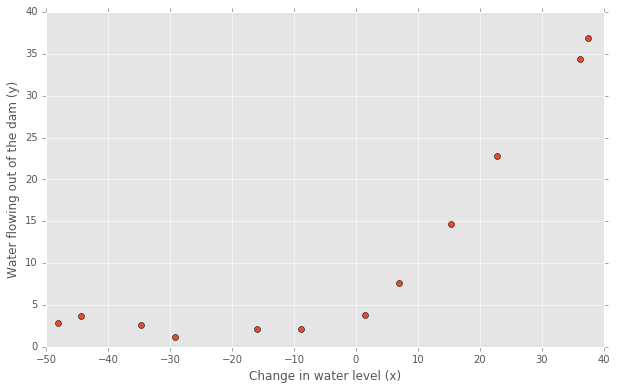

In [141]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex5-005\\mlclass-ex5\ex5data1.mat')

X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X, y, 'o', label='Raw Data')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
plt.show()

In [142]:
def computeCost(theta, X, y, lamb):
    residual = X.dot(theta) - y
    m = y.shape[0]
    
    cost = 1/(2*m) * (residual**2).sum() + lamb/(2*m) * (theta[1:,]**2).sum()
    return np.asscalar(cost.squeeze())

def computeGradient(theta, X, y, lamb):
    theta = theta.reshape(-1, 1)
    residual = X.dot(theta) - y
    m = y.shape[0]

    gradient = 1/m * X.T.dot(residual)
    gradient[1:] += lamb/m * theta[1:,]
    return gradient.flatten()

def gradientDescent(X, y, theta, alpha, num_iters, lamb):
    m = y.shape[0]
    J_history = np.zeros((num_iters, 1))
    for iter in range(num_iters):
        residual = X.dot(theta) - y
        gradient = alpha/m * X.T.dot(residual)
        gradient[1:] += lamb/m * theta[1:,]
        temp = theta - gradient
        theta = temp
 
        J_history[iter,0] = computeCost(theta, X, y, lamb)
    return theta, J_history

def learningCurve(X, y, Xval, yval, lamb):
    m = y.shape[0]
    alpha = 0.001
    iterations = 3000
    train_error = np.zeros(m)
    validation_error = np.zeros(m)

    for i in range(1,m+1):
        theta_opt, J_history = gradientDescent(X[:i,:], y[:i,:], initial_theta, alpha, iterations, lamb)
        train_error[i-1] = computeCost(theta_opt, X[:i,:], y[:i,:], 0)
        validation_error[i-1] = computeCost(theta_opt, Xval, yval, 0)     
    
    return train_error, validation_error

def polyFeatures(X, p):
    X = np.c_[X, np.zeros((X.shape[0], p-1))]
    for i in range(2, p+1):
        X[:, i-1] = X[:,0]**i
    return X

def featureNormalize(X):
    average = np.mean(X, axis=0)
    sigma = np.std(X, axis= 0)
    X = (X-average)/sigma
    return X, average, sigma

def getExtendedX(min_x, max_x, average, sigma, p):
    X = np.arange(min_x-15, max_x+15, 0.05).reshape(-1,1)
    
    X_poly = polyFeatures(X, p)
    X_poly = (X_poly - average)/sigma
    X_poly = np.c_[np.ones(X_poly.shape[0]), X_poly]
    
    return X, X_poly

def validationCurve(X, y, Xval, yval, lamb_vector):
    m = lamb_vector.shape[0]
    alpha = 0.001
    iterations = 10000
    train_error = np.zeros(m)
    validation_error = np.zeros(m)

    for i, lamb in enumerate(lamb_vector):
        theta_opt, J_history = gradientDescent(X, y, initial_theta, alpha, iterations, lamb)
        train_error[i] = computeCost(theta_opt, X, y, 0)
        validation_error[i] = computeCost(theta_opt, Xval, yval, 0)     
    
    return train_error, validation_error

In [143]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex5-005\\mlclass-ex5\ex5data1.mat')

X = data['X']
y = data['y']
X = np.c_[np.ones(X.shape[0]), X]

lamb = 1
theta = np.ones((X.shape[1], 1))
cost = computeCost(theta, X, y, lamb)
grad = computeGradient(theta, X, y, lamb)

print('Cost @theta = [1,1]; @lambda = 1:', cost)
print('Gradient of cost @theta = [1,1]; @lambda = 1:', grad)

Cost @theta = [1,1]; @lambda = 1: 303.9931922202643
Gradient of cost @theta = [1,1]; @lambda = 1: [ -15.30301567  598.25074417]


In [144]:
initial_theta = np.ones((X.shape[1], 1))
lamb = 0
alpha = 0.001
iterations = 3000

theta_opt, J_history = gradientDescent(X, y, initial_theta, alpha, iterations, lamb)
print("Theta found by gradient descent: intercept={0}, slope={1}".format(theta_opt[0][0],theta_opt[1][0]))

Theta found by gradient descent: intercept=12.429578749530522, slope=0.3638309780847176


Checking minimization of the cost function...


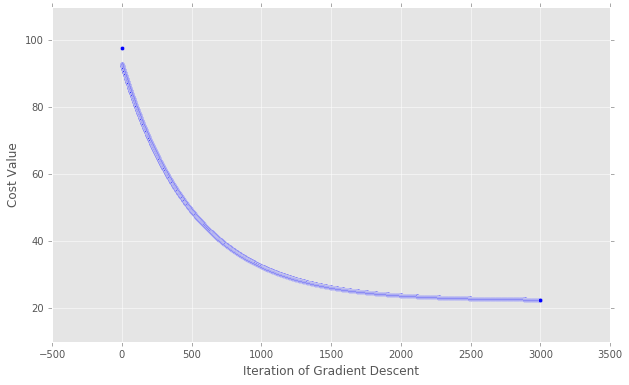

In [145]:
print('Checking minimization of the cost function...')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(range(iterations), J_history)
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

A straight line does not really do the job...


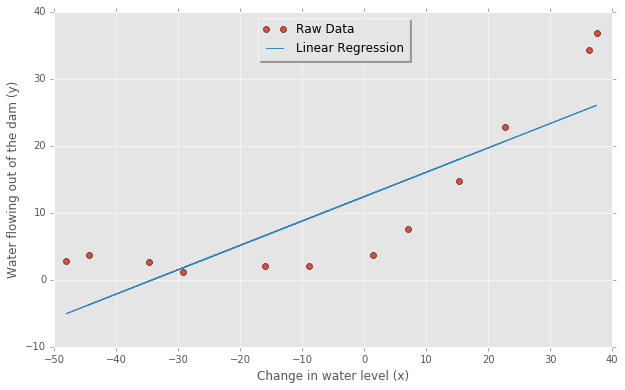

In [146]:
optimal_theta = theta_opt
print('A straight line does not really do the job...')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X[:,1], y, 'o', label='Raw Data')
ax.plot(X[:,1], np.dot(X, optimal_theta), linestyle='-', label='Linear Regression')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

It is evident that a straight line does not model the true relationship between X and y. The method is not flexible enough, resulting in high bias and low variance. The finding is proved by the below learning curve as well. 

A learning curve shows the error on the Training Set v.s. Validation Set for an increasing number of data points ingested in the learning process. As you can see, as soon as the training set increases in size the train error grows while the validation error goes down. Despite that, the two quantities end up both pretty high, showing that the method doesn't fit well neither of the two data sets.

In [147]:
Xval = np.c_[np.ones(Xval.shape[0]), Xval]
lamb = 0

train_error, validation_error = learningCurve(X, y, Xval, yval, lamb)

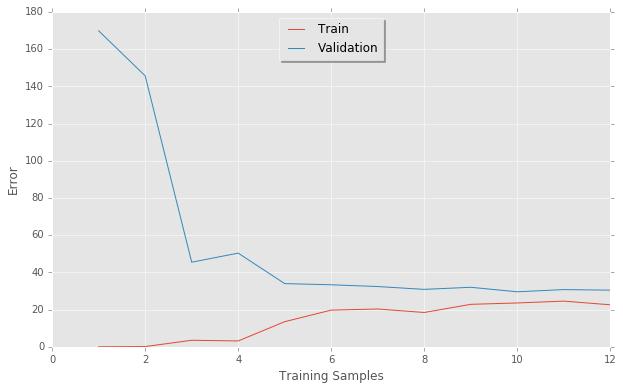

In [148]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(1, X.shape[0]+1) , train_error, '-', label='Train')
ax.plot(np.arange(1, X.shape[0]+1) , validation_error, linestyle='-', label='Validation')
plt.ylabel('Error')
plt.xlabel('Training Samples')
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

## Multivariate Polynomial Regression - Low Bias, High Variance 

As we saw above, a straight line is too simplistic to model our data. Something more flexible is needed. We'll get just that with the expansion of the feature space adding up to the 11-th power polynomial of X. This is actually way too flexible! It won't get unnoticed that the curve fits almost perfectly all the data points resulting in unnatural and non sensical trends outside of the boundaries of the X space. Regularization comes to the rescue here, shrinking back all our parameters and re-establishing a balance in the bias-variance trade-off. 

In [149]:
data = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex5-005\\mlclass-ex5\ex5data1.mat')

X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']
p = 11

# it is important to normalize and scale our dataset before applying any ML on it
X_poly = polyFeatures(X, p)
X_poly, average, sigma = featureNormalize(X_poly)
X_poly = np.c_[np.ones(X_poly.shape[0]), X_poly]

X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - average)/sigma
X_poly_val = np.c_[np.ones(X_poly_val.shape[0]), X_poly_val]

X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - average)/sigma
X_poly_test = np.c_[np.ones(X_poly_test.shape[0]), X_poly_test]

An 11th degree polynomial is way too wiggly!


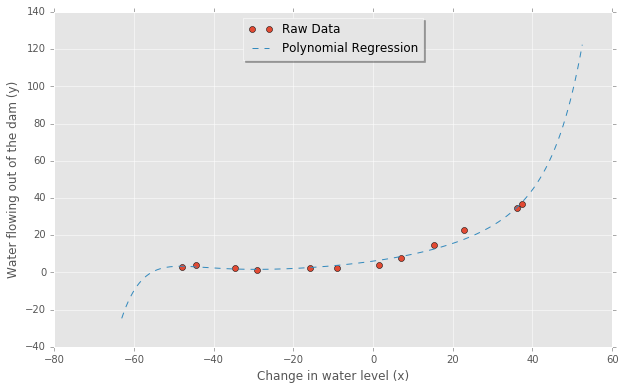

In [150]:
initial_theta = np.ones((X_poly.shape[1], 1))
lamb = 0
alpha = 0.001
iterations = 10000

theta_opt_poly, J_history_poly = gradientDescent(X_poly, y, initial_theta, alpha, iterations, lamb)

X_ext, X_ext_poly = getExtendedX(min(X), max(X), average, sigma, p)

print('An 11th degree polynomial is way too wiggly!')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X, y, 'o', label='Raw Data')
ax.plot(X_ext[:,0], np.dot(X_ext_poly, theta_opt_poly), '--', label='Polynomial Regression')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). 

The polynomial fit, on the contrary, is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial method is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve (two plots below) shows the same effect where the training error is low, but the validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

The above curve does not do a good job as a predictive model. To remedy the situation we have to reduce the variance. Regularization come to the rescue; specifically we apply below the "validation set approach" to select the "best" value of lambda, minimizing the validation set error.

Checking minimization of the cost function...


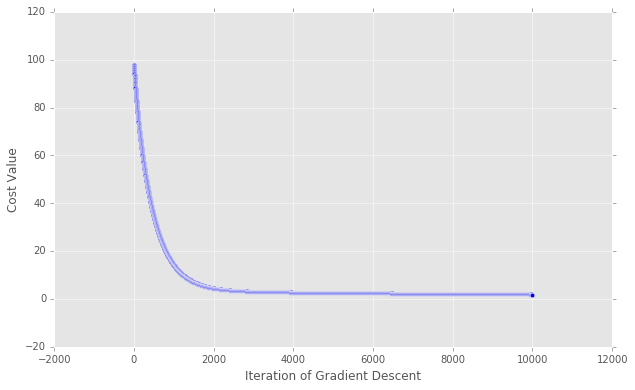

In [151]:
print('Checking minimization of the cost function...')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(range(iterations), J_history_poly)
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

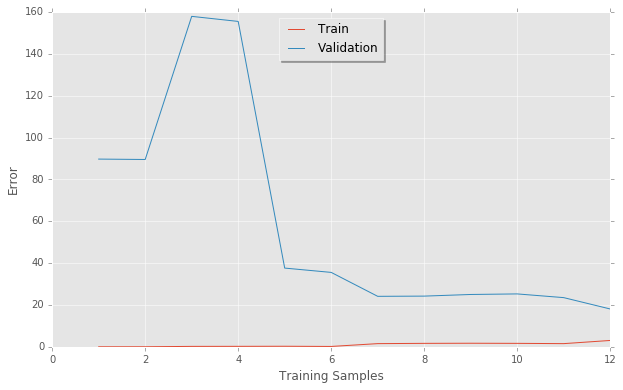

In [152]:
lamb = 0
train_error_poly, validation_error_poly = learningCurve(X_poly, y, X_poly_val, yval, lamb)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(1, X.shape[0]+1) , train_error_poly, '-', label='Train')
ax.plot(np.arange(1, X.shape[0]+1) , validation_error_poly, linestyle='-', label='Validation')
plt.ylabel('Error')
plt.xlabel('Training Samples')
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

### Selecting the optimal lambda with CV 

The below chart shows the relation between the Train and Validation Set.

As expected, the former steadily increase with $\lambda$, whereas the latter takes a dip before growing again. The value of $\lambda$ (0.004) minimizing the validation error is the one we want to use for our final model. 

In [153]:
lamb_vector = np.arange(0, 0.1, 0.001)

train_error_lamb, validation_error_lamb = validationCurve(X_poly, y, X_poly_val, yval, lamb_vector)

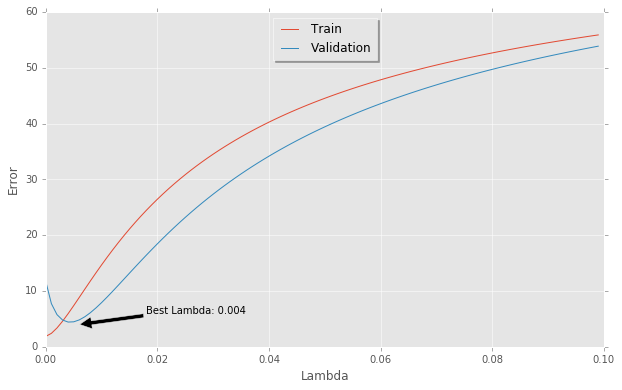

In [154]:
lambdas = lamb_vector
train = train_error_lamb
valid = validation_error_lamb

best_lambda = pd.DataFrame(
    {'lambdas': lambdas,
     'train_cost': train,
     'validation_cost': valid
    })

l = best_lambda.lambdas[best_lambda.validation_cost.argmin()]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(lamb_vector , train_error_lamb, '-', label='Train')
ax.plot(lamb_vector , validation_error_lamb, linestyle='-', label='Validation')
ax.annotate("Best Lambda: %.3f" % l, xy=(0.006, 4), xytext=(0.018, 6),
            arrowprops=dict(facecolor='black', shrink=0.005))
plt.ylabel('Error')
plt.xlabel('Lambda')
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

### How does our model perform on unseen data?

In [155]:
initial_theta = np.ones((X_poly.shape[1], 1))
lamb = 0.004
alpha = 0.001
iterations = 10000

theta_optimal, J_history_poly = gradientDescent(X_poly, y, initial_theta, alpha, iterations, lamb)

test_error = computeCost(theta_optimal, X_poly_test, ytest, 0.004)
print("The test error at the optimal @lambda = 0.04 is equal to %.2f" % test_error)

The test error at the optimal @lambda = 0.04 is equal to 4.71


### Appendix: how do we estimate the error of our model? 

The error for a dataset is defined as 

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$

This is nothing more than the cost function when we set $\lambda$ to zero. Therefore we don't need an additional logic to calculate the error. We just call the *computeCost* function with $\lambda = 0$ and we'll get the wished result